# Default on Credit Card Loan 


The project consists of the following:

1. Introduction

2. Exploring The Data

   2.1 The Data

3. Exploratory Data Analysis (EDA)

   3.1 Describing Features

   3.2 Descriptive Figures

       3.2.1 Distribution Plots

       3.2.2 Boxplots

       3.2.3 Cross-correlation Plot

       3.2.4 Distribution Plots With Respect To Our Target Feature

       3.2.5 Pair Plots With Respect To Our Target Feature

   3.3 Feature Engineering

       3.3.1 Skewed Features: Log Transform

       3.3.2 Removing Some Features

       3.3.3 Normalization Of Numerical Features

 
4. Model Selection

   4.1 Data Preparation: Training and Testing Sets

   4.2 Model Selection: Logistic Regression

       4.2.1 Logistic Regression

       4.2.2 Confusion Matrix, Precision, Recall, F1-Score

5. Actionable Recommendations

# 1. Introduction

In this project, we're trying to solve the problem of increase in customer default rates, which is likely to result in the loss of revenue.

Business problems:

1. Increase in customer default rates - This is bad for Credit One since they approve the customers for loans in the first place.
2. Revenue and customer loss for clients and, eventually, loss of clients for the loan company.

The key questions to investigate:

- How to ensure that customers can/will pay their loans?
- Which customers can we approve with high certainty?

In [2]:
# Importing librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, fbeta_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [3]:
# Parelle processing
import multiprocessing as mp
print("6: ", mp.cpu_count())

6:  8


# 2. Exploring the Data

In [4]:
# Loading the data
credit = pd.read_csv('default.csv')
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Remove unmeaningful column
credit = credit.drop('ID', axis =1)

In [6]:
credit.info()
print()
print(credit.isnull().any()) # Check missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

In [7]:
# Assessing if duplicated records are found in the dataset
print("Number of duplicated records in training set: ", credit.duplicated().sum())

Number of duplicated records in training set:  35


In [8]:
# Removing the duplicated rows from the dataset
credit = credit.drop_duplicates()

## 3. Exploratory Data Analysis (EDA)

In this exploratory data analysis, we'll investigate the relationship between each predictor and how they impact customer default rate. 

### 3.1 Describing the Features

In [9]:
# Looking at the distribution of the target feature
default_rate = credit["default payment next month"].value_counts() / credit.shape[0]
default_rate

0    0.778742
1    0.221258
Name: default payment next month, dtype: float64

As you can see, 78% of the observations are 0, so this is an imbalanced dataset. This might affect the accuracy of machine learning models because it's completely ignoring the minority class in favor of the majority class. 
We'll up-sample the minority class later to handle the imbalanced classes. 

In [10]:
# Extract Descriptive Statistics
credit.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,1.603738,1.853629,1.551877,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,...,43313.329885,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.221258
std,129760.135222,0.489128,0.790411,0.521997,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,...,64353.514373,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2360.000000,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19081.000000,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54601.000000,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


The demographic variables do not seem to be very skewed as we can see the mean the median are roughly similar, but bill amount and payment amount variables can have a very wide range. 

Also, education is slightly skewed because very few observations fall into 'others'categories, which doesn't provide any meaningful insights for us, so below we'll shorten the range of education by combining the levels.  

In [11]:
# Check the distribution of education feature. 0,4,5,6 = others
valCount = credit['EDUCATION'].value_counts()
valCount

2    14019
1    10563
3     4915
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [12]:
# Combine all the levels that represent others 
need = credit['EDUCATION'].value_counts().index[:3]
credit['EDUCATION'] = np.where(credit['EDUCATION'].isin(need), credit['EDUCATION'], 0)
valCount = credit['EDUCATION'].value_counts()
print (valCount)

2    14019
1    10563
3     4915
0      468
Name: EDUCATION, dtype: int64


## 3.2 Descriptive Figures

### 3.2.1 Cross-correlation Plot

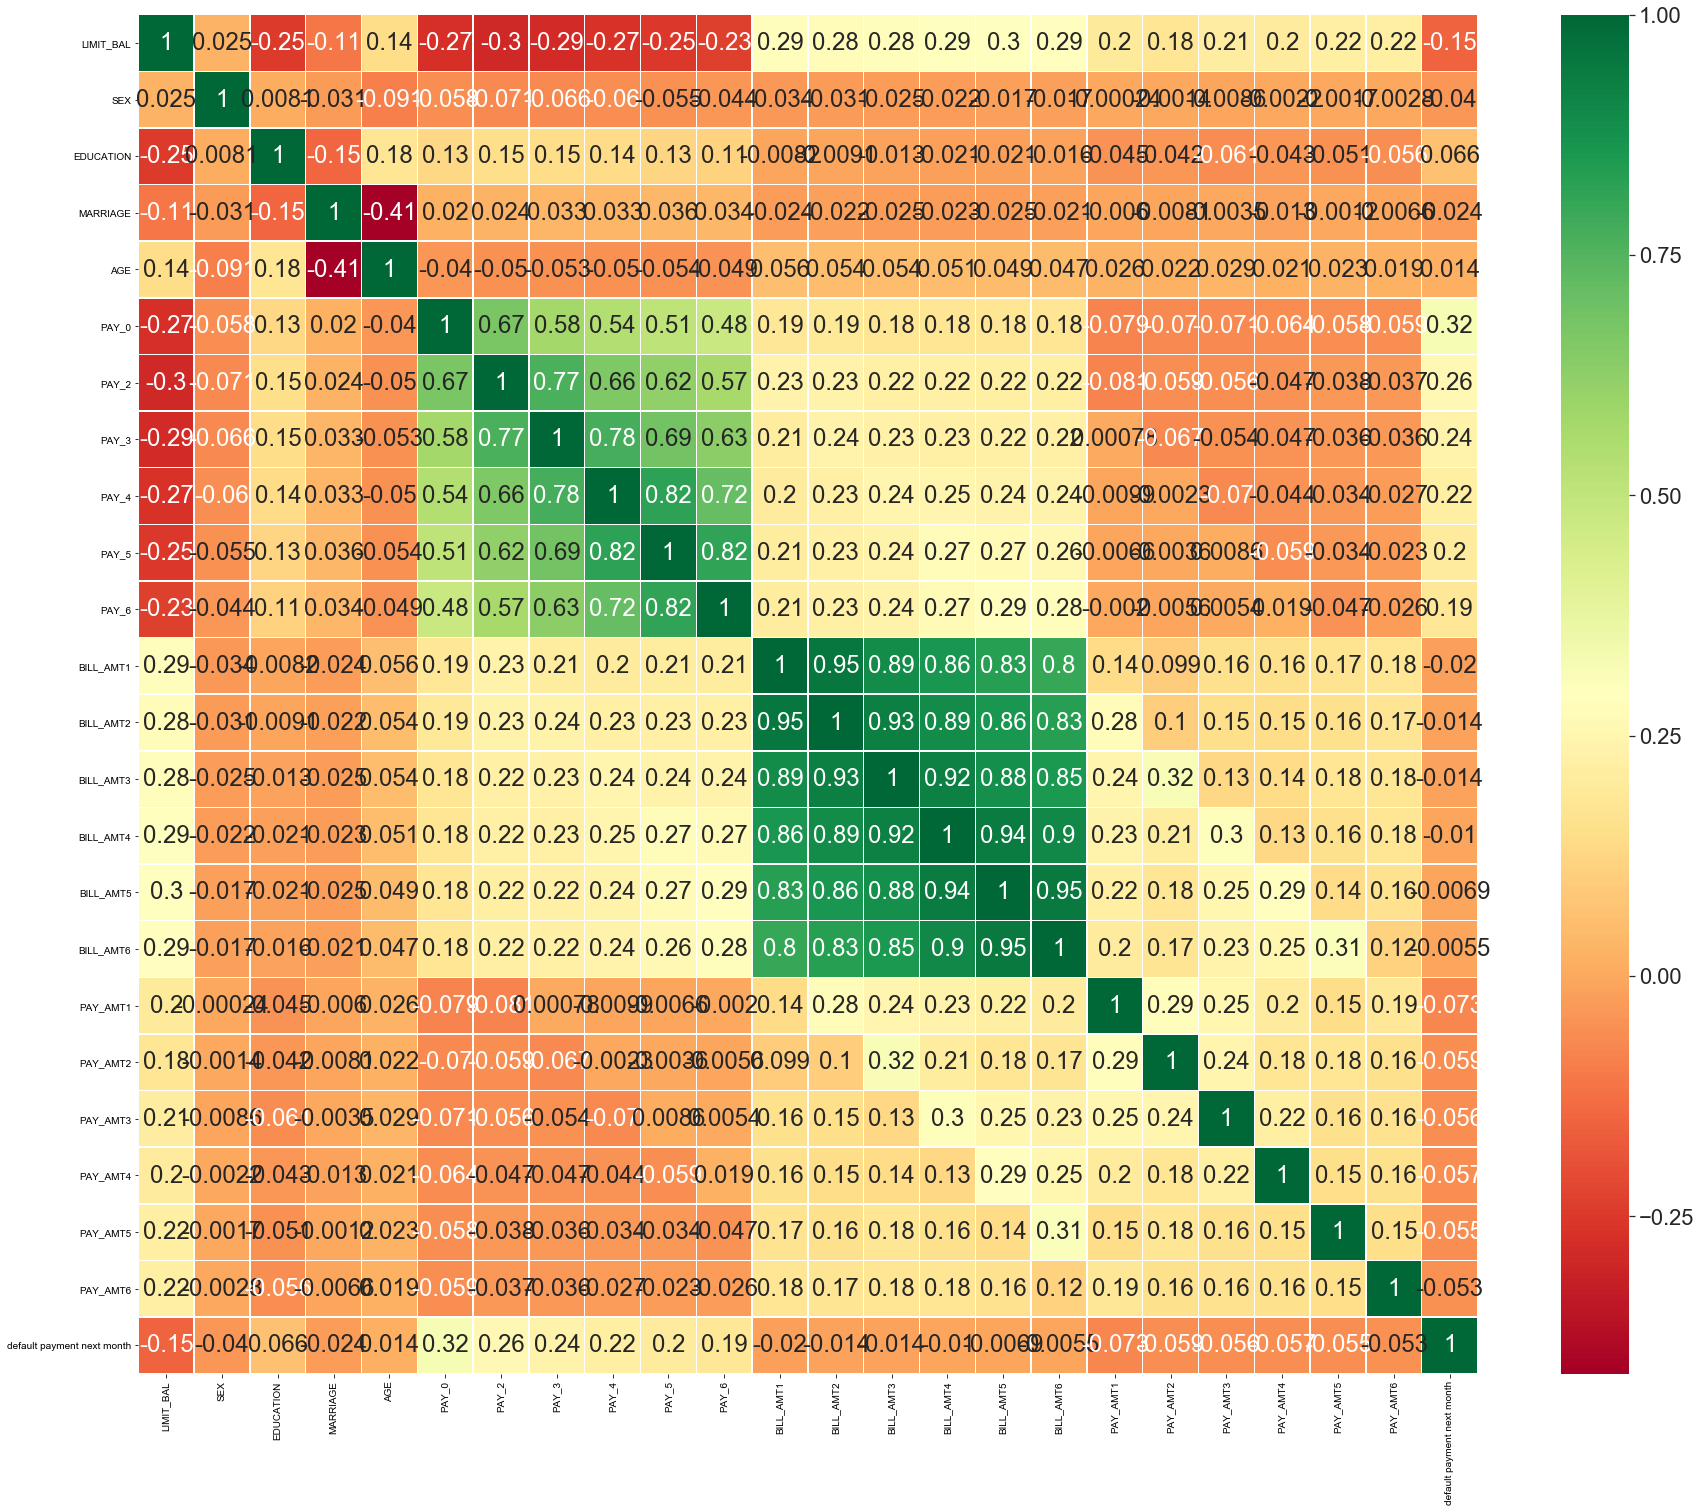

In [13]:
# Create heatmap 
corrMat = credit.corr()
top_corr_features = corrMat.index
fig, ax = plt.subplots(figsize=(30,25))  
sns.set(font_scale=2)
g1=sns.heatmap(credit[top_corr_features].corr(),annot=True,cmap="RdYlGn",linewidths=.5, ax=ax)

In this heatmap, green indicates that the features are highly correlated, and red indicates that they are not correlated. We can see that the most relavant features are payment history, followed by payment amount. 

In [14]:
# Find highly correlated variables
corr = credit.corr().abs()
corr[corr == 1] = 0
corr_cols = corr.max().sort_values(ascending=False)
display(corr_cols[corr_cols > 0.75])

BILL_AMT1    0.951457
BILL_AMT2    0.951457
BILL_AMT6    0.946170
BILL_AMT5    0.946170
BILL_AMT4    0.940103
BILL_AMT3    0.928287
PAY_5        0.819322
PAY_4        0.819322
PAY_6        0.816387
PAY_3        0.776731
PAY_2        0.765965
dtype: float64

In the feature selection process, we can see that all the bill amount variables are highly correlated with each other, so are all the payment history variables. We might want to remove the highly correlated variables for modeling. 

### 3.2.2 Distribution Plots

In [15]:
# Functions that we will use later on
def data_info(data):
    return data.info()

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])

In [16]:
features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE', 'PAY_0']
target = 'default payment next month'

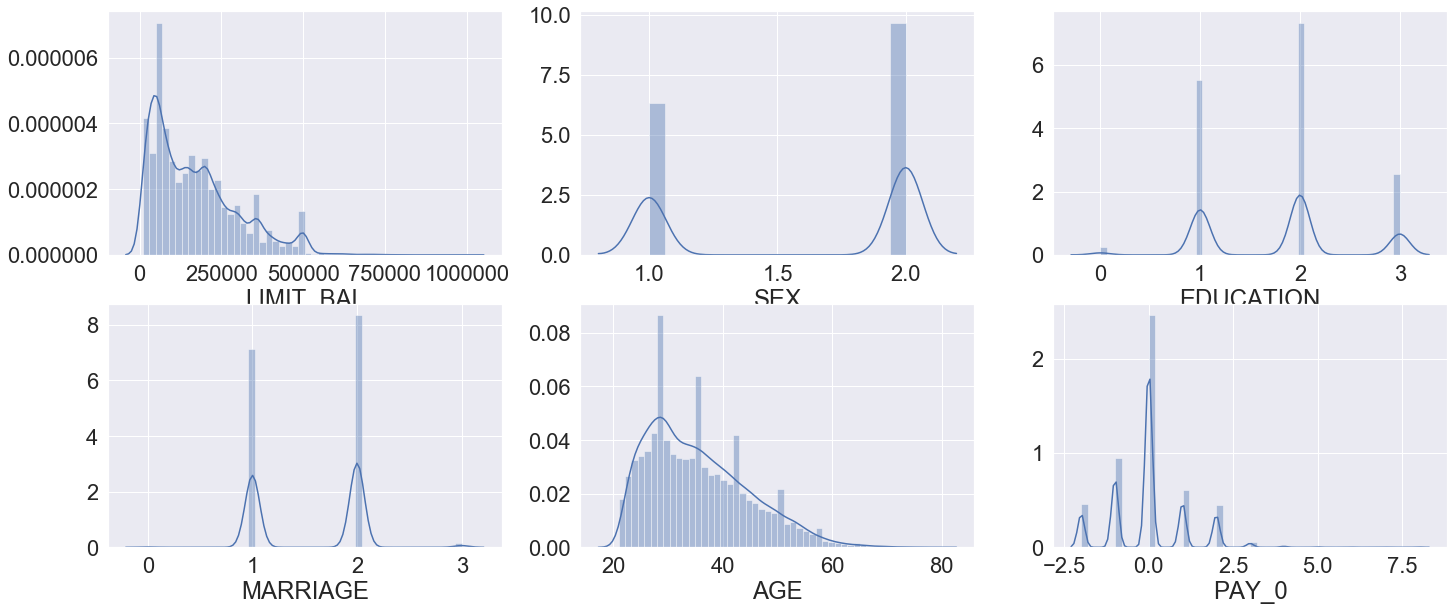

In [17]:
# Creating distribution plots
creating_distplot((24,26), credit, features)

### 3.2.3 Boxplot

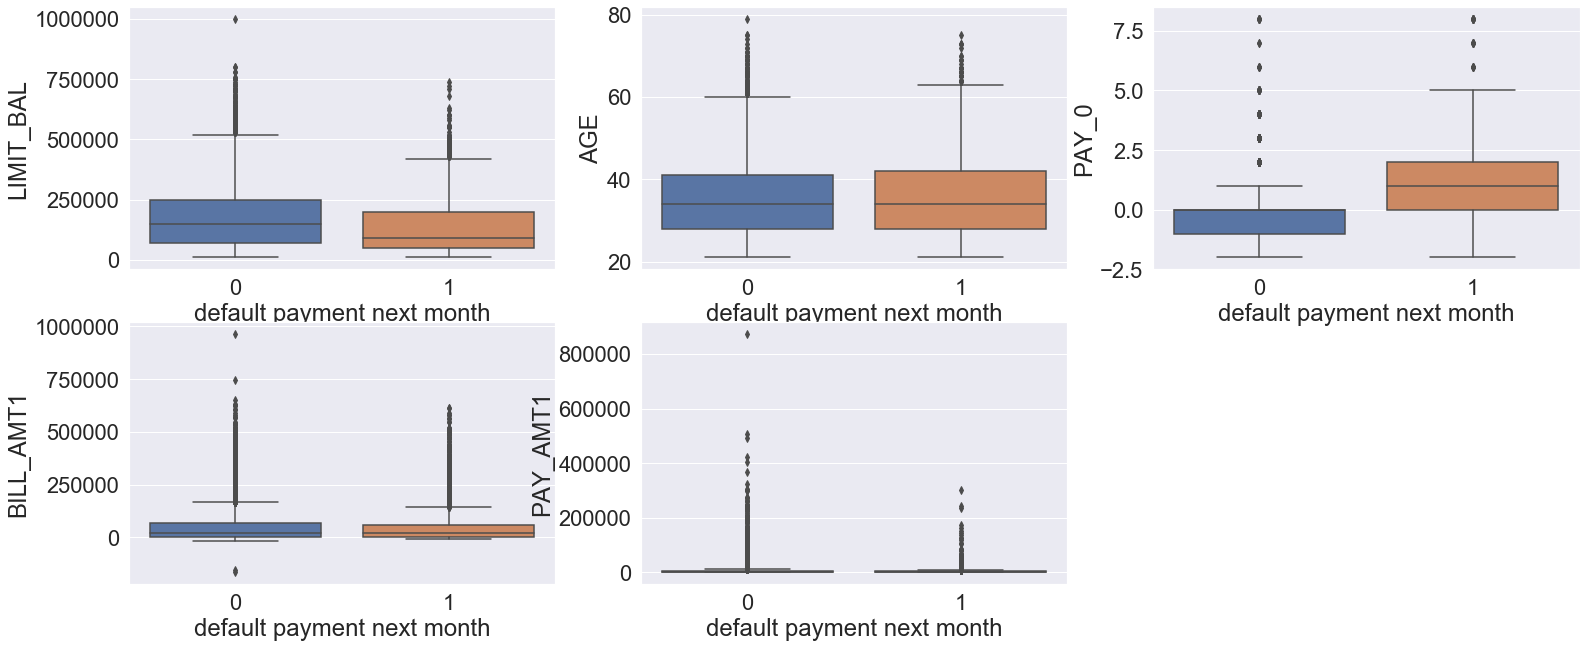

In [18]:
# Generating boxplots of numerical variables with respect to the target feature
numerical_vars = ['LIMIT_BAL','AGE', 'PAY_0', 'BILL_AMT1','PAY_AMT1']
creating_boxplots((26,28), target, numerical_vars, credit)

### 3.2.4 Demographic Variables With Respect To Target Feature

C:\Users\Noxar\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


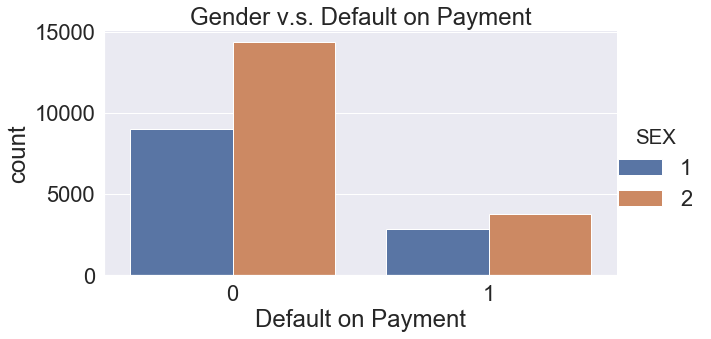

In [19]:
# Sex and default payment (1 = male; 2 = female)
g = sns.factorplot('default payment next month', data=credit, hue='SEX', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="Gender v.s. Default on Payment")

Among the customers who fail to pay on time, female is slightly more than male. Gender might be a good predictor but we need to look at it with other demographic predictors.

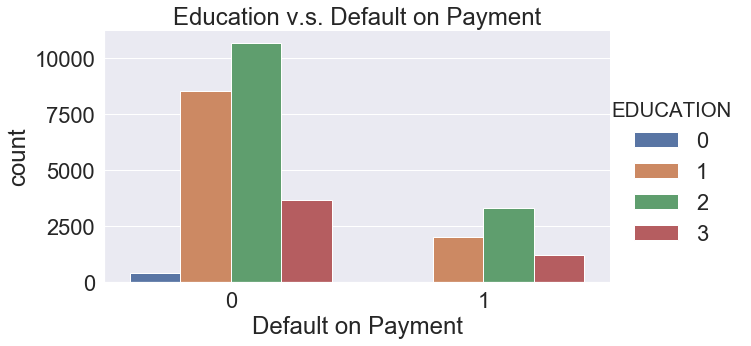

In [20]:
# Education and default payment (1 = graduate school; 2 = university; 3 = high school; 0 = others) 
g = sns.factorplot('default payment next month', data=credit, hue='EDUCATION', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="Education v.s. Default on Payment")

Among the customers who fail to pay on time, most of them have a college degree, followed by a graduate degree and a high school diploma, which is consistent with the composition of customers' education level. It indicates that education is not a strong predictor of default payment.

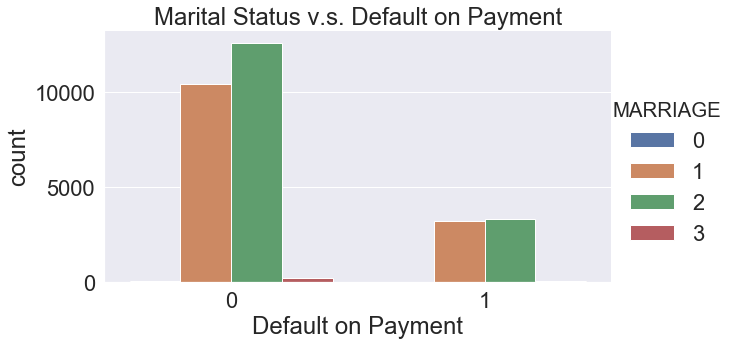

In [21]:
# clients' marital status and default payment (1 = married; 2 = single; 3 = divorce; 0=others). 
g = sns.factorplot('default payment next month', data=credit, hue='MARRIAGE', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="Marital Status v.s. Default on Payment")

Among the cutomers who fail on payments, about half are married and half ar single; marrital status alone is not enough to predict default payment.

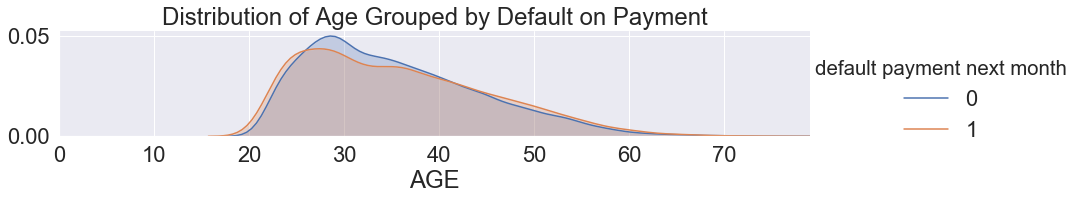

In [22]:
fig = sns.FacetGrid(credit, hue='default payment next month', aspect=4)
fig.map(sns.kdeplot, 'AGE', shade=True)
oldest = credit['AGE'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Age Grouped by Default on Payment')
fig.add_legend()

There's not significant difference of age distribution between customers who pay on time and those who fail payments, so age is not a strong predictor, which matches the result of box plot. We can only say that majority of the customers are in their mid 20's to late 30's.   

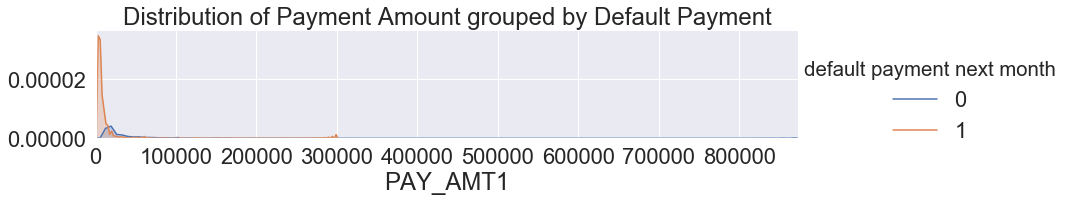

In [23]:
# distribution of Sep. payment amount grouped by default payment 
fig = sns.FacetGrid(credit, hue='default payment next month', aspect=4)
fig.map(sns.kdeplot, 'PAY_AMT1', shade=True)
oldest = credit['PAY_AMT1'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Payment Amount grouped by Default Payment')
fig.add_legend()

Credit limit, bill amount and payment amount all have a skewed distribution towards the smaller amount. Payment amounts of clients who failed on next month's payments are significantly smaller.

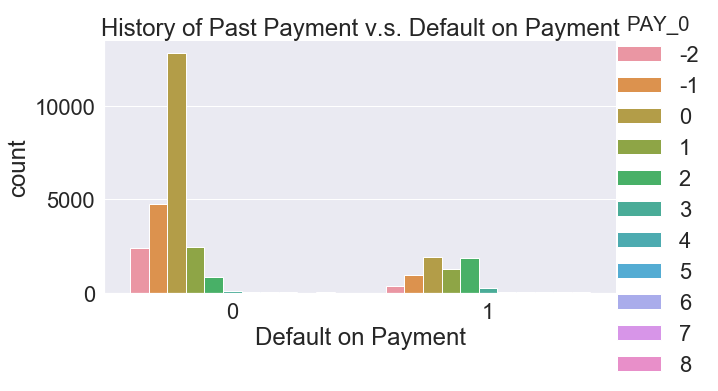

In [24]:
# Sep.payment history and default payment next month (-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay 1 month)
g = sns.factorplot('default payment next month', data=credit, hue='PAY_0', kind='count', aspect=1.75)
g.set_xlabels('Default on Payment')
g.set(title="History of Past Payment v.s. Default on Payment")

We can see that there's a significant amount of customers who make their payment on time use their revolving credits; whereas customers who fail to make payment are likely to use revolving credits or late for 1 or 2 months.  

### 3.2.4.1 Analysis on customers who default on payments based on their demographic variables

We'll look at the relavant demographic variables: gender, marrital status, and education and their relations with the target feature.  

#### Default on payment grouped by gender and merital status

In [25]:
credit.pivot_table('default payment next month', 'SEX', 'MARRIAGE', aggfunc=np.sum, margins=True)

MARRIAGE,0,1,2,3,All
SEX,,,,,
1,2,1343,1484,40,2869
2,3,1858,1856,44,3761
All,5,3201,3340,84,6630


Single women are most likely to fail payments, followed by married women and married men. Divorced men are women are least likely to fail on payments. Gender has a significant impact on the chances of defaulting payments for single and married people, but not for divorced people.

#### Default on payment grouped by gender and education

In [26]:
credit.pivot_table('default payment next month', 'SEX', 'EDUCATION', aggfunc=np.sum, margins=True)

EDUCATION,0,1,2,3,All
SEX,,,,,
1,14,904,1406,545,2869
2,19,1128,1922,692,3761
All,33,2032,3328,1237,6630


Women with a college degree are most likely to default on a payment, followed by men with a college degree. Men with a high scholl diploma are least likely to fail on payment, followed by women with a high school diploma. Gender has a significant impact on people with a college degree, but not so much on the others.

#### Default on payment grouped by marital status and education 

In [27]:
credit.pivot_table('default payment next month', 'MARRIAGE', 'EDUCATION', aggfunc=np.sum, margins=True)

EDUCATION,0,1,2,3,All
MARRIAGE,,,,,
0,NaN,0.0,1.0,4.0,5
1,17.0,765.0,1665.0,754.0,3201
2,16.0,1254.0,1618.0,452.0,3340
3,0.0,13.0,44.0,27.0,84
All,33.0,2032.0,3328.0,1237.0,6630


Single people with a college degree are most likely to default on payments, followed by married people with a college degree and married people wuth a graduate degree. Marital status only has significant impact on the chances of defaulting on payments when clients have a graduate degree.

## 3.3 Feature Engineering

### 3.3.1 Skewed Features: Log Transform

In [28]:
credit["log_age"] = np.log(credit["AGE"])
credit["log_limit"] = np.log(credit["LIMIT_BAL"])

In EDA we see that some features have skewed distributions. We'll apply logarithmic transformation to reduce the effect of outliers and reduce the range of distributions.

### 3.3.2 Feature Selection

In [29]:
df = credit.loc[:,["SEX","EDUCATION","MARRIAGE","log_age","log_limit","PAY_0","PAY_3","PAY_5","default payment next month"]]

In the feature selection process, we'll remove the bill amount and payment amount variables since they have a very wide range and are less relavant to the business problem: pre-qualifying customers with high certainty. We'll also remove the even numbers of payment history variables because they are highly correlated to each other.

### 3.3.3 Normalization Of Numerical Features

In [30]:
# Defining categorical, numerical, and datetime variables that we will use later
numerical_vars = ["SEX","EDUCATION","MARRIAGE","log_age","log_limit","PAY_0","PAY_3","PAY_5"]
target = "default payment next month"

# Initialize a scaler, then apply it to the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # default=(0, 1)

# Applying the MinMax transformation of the numerical variables
data = pd.DataFrame(data = df)
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])

# Show an example of a record with scaling applied
data.head()

,SEX,EDUCATION,MARRIAGE,log_age,log_limit,PAY_0,PAY_3,PAY_5,default payment next month
0,1.0,0.666667,0.333333,0.100784,0.150515,0.4,0.1,0.0,1
1,1.0,0.666667,0.666667,0.161197,0.539591,0.1,0.2,0.2,1
2,1.0,0.666667,0.666667,0.363672,0.477121,0.2,0.2,0.2,0
3,1.0,0.666667,0.333333,0.427492,0.349485,0.2,0.2,0.2,0
4,0.0,0.666667,0.333333,0.753649,0.349485,0.1,0.1,0.2,0


### 3.3.4 Up-sample Minority Class

In the exploratory data analysis we fould that the target feature has imbalanced classes, so we'll use up-sampling to randomly duplicate observations from the minority class in order to reinforce its signal.

In [31]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data[data[target]==0]
df_minority = data[data[target]==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=23335,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled[target].value_counts()

1    23335
0    23335
Name: default payment next month, dtype: int64

# 4. Model Selection

In this section, we will test different algorithms and tune the model's parameters to choose the best fit of this dataset. In this case, false negatives are crucial because customers who are predicted to pay on time but fail to pay can cause huge loss for the company, so we'll use F-1 Score and confision matrix as metrics to minimize the number of false negatives.


## 4.1 Data Preparation: Training and Testing Sets

In [32]:
# Creating training and test set 
X, y = data.drop([target],1).values, data[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=y)

In [33]:
# sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20975, 8)
(20975,)
(8990, 8)
(8990,)


## 4.2 Model Selection: Logistic Regression

### 4.2.1 Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression


parameters = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F


Optimized Model
------
Final accuracy score on the testing data: 0.8105
Final F-score on the testing data: 0.5057
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Noxar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.8067
Final F-score on the testing data: 0.4896
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [36]:
parameters = {"C": [600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.8067
Final F-score on the testing data: 0.4896
LogisticRegression(C=600, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [37]:
parameters = {"C": [125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600]}

model = LogisticRegression(random_state=42, penalty="l2")

# fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_train)

# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print(best_clf)


Optimized Model
------
Final accuracy score on the testing data: 0.8067
Final F-score on the testing data: 0.4896
LogisticRegression(C=150, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


### 4.2.2 Confusion Matrix, Precision, Recall, F1-Score

In [38]:
# Confusion matrix
confmat = confusion_matrix(y_train, best_predictions)
print("The Confusion matrix:\n", confmat)
print("Precision Score:", round(precision_score(y_train, best_predictions), 2))
print("Recall Score:", round(recall_score(y_train, best_predictions), 2))

The Confusion matrix:
 [[15885   449]
 [ 3605  1036]]
Precision Score: 0.7
Recall Score: 0.22


Text(0, 0.5, 'Frequency')

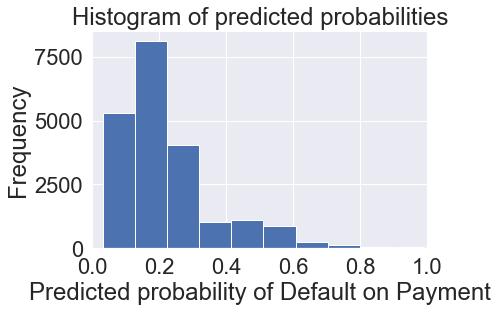

In [39]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1]

plt.rcParams["font.size"]= 14
plt.hist(y_pred_prob, bins=10)
plt.xlim(0, 1)
plt.title("Histogram of predicted probabilities")
plt.xlabel("Predicted probability of Default on Payment")
plt.ylabel("Frequency")

In [40]:
y_pred_prob = best_clf.predict_proba(X_train)[:,1]
y_pred_class = np.where(y_pred_prob<0.2,0,1)

confmat = confusion_matrix(y_train, y_pred_class)
print("The Confusion matrix:\n", confmat)
print("Precision Score:", round(precision_score(y_train, y_pred_class), 2))
print("Recall Score:", round(recall_score(y_train, y_pred_class), 2))

The Confusion matrix:
 [[10027  6307]
 [ 1410  3231]]
Precision Score: 0.34
Recall Score: 0.7


## 4.3 Random Forest

### 4.3.1 Tuning Parameters

### Max Depth

1 depth
AUC Train:  0.8195644468899822
AUC Test:  0.6128303943363976
 
5 depth
AUC Train:  0.8896686788795635
AUC Test:  0.6269402798091976
 
10 depth
AUC Train:  0.896935423160043
AUC Test:  0.6261265628288827
 
20 depth
AUC Train:  0.9194815393073809
AUC Test:  0.6351049182157343
 
50 depth
AUC Train:  0.9273207705438563
AUC Test:  0.6380415812177662
 
70 depth
AUC Train:  0.9282279733341755
AUC Test:  0.6359562653873552
 
75 depth
AUC Train:  0.9278876708777529
AUC Test:  0.6370788515524142
 
80 depth
AUC Train:  0.9278717684623086
AUC Test:  0.6361047753789968
 
85 depth
AUC Train:  0.9274396330194773
AUC Test:  0.6384386371867152
 
90 depth
AUC Train:  0.9281337526769285
AUC Test:  0.6371103057962919
 
95 depth
AUC Train:  0.9277481306450113
AUC Test:  0.639121366630882
 
100 depth
AUC Train:  0.9275938818322442
AUC Test:  0.6376473618758335
 


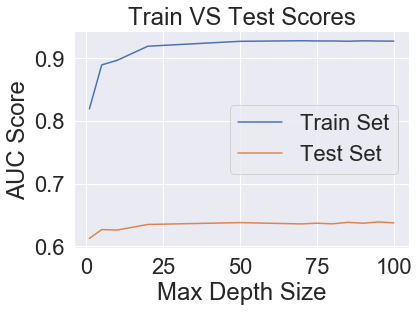

In [48]:
from sklearn.metrics import roc_auc_score

results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,10,20,50,70,75,80,85,90,95,100]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=42)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="right")
plt.show()

### n_estimators

1 trees
AUC Train:  0.8195644468899822
AUC Test:  0.6128303943363976
 
2 trees
AUC Train:  0.778555705561086
AUC Test:  0.5878395666955285
 
3 trees
AUC Train:  0.8682874031209153
AUC Test:  0.6228464884245152
 
4 trees
AUC Train:  0.8448252986098982
AUC Test:  0.6065331541734073
 
5 trees
AUC Train:  0.8896686788795635
AUC Test:  0.6269402798091976
 
15 trees
AUC Train:  0.9186808780834955
AUC Test:  0.6344134275438207
 
25 trees
AUC Train:  0.9250042681265177
AUC Test:  0.6349048462444028
 
40 trees
AUC Train:  0.9269693410136657
AUC Test:  0.6348535356114106
 
50 trees
AUC Train:  0.9273207705438563
AUC Test:  0.6380415812177662
 
60 trees
AUC Train:  0.9276586853294406
AUC Test:  0.6389728566392405
 
70 trees
AUC Train:  0.9282279733341755
AUC Test:  0.6359562653873552
 
80 trees
AUC Train:  0.9278717684623086
AUC Test:  0.6361047753789968
 
100 trees
AUC Train:  0.9275938818322442
AUC Test:  0.6376473618758335
 


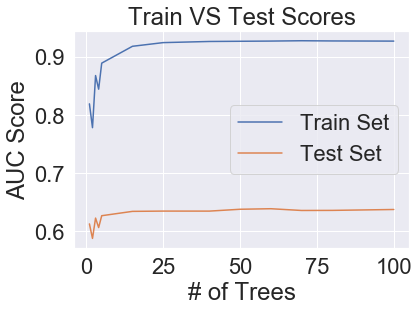

In [49]:
from sklearn.metrics import roc_auc_score

results = []
results2 = []
n_estimator_options = [1, 2, 3, 4, 5, 15, 25, 40, 50, 60, 70, 80, 100]

for trees in n_estimator_options:
    model = RandomForestClassifier(trees, oob_score=True, n_jobs=-1, random_state=42)
    
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(n_estimator_options, results, label='Train Set')
plt.plot(n_estimator_options, results2, label='Test Set')
plt.xlabel('# of Trees')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="right")
plt.show()

### Max Features

auto option
AUC:  0.7868414779499404
 
None option
AUC:  0.7812157330154946
 
sqrt option
AUC:  0.7868414779499404
 
log2 option
AUC:  0.7885101311084625
 
0.7 option
AUC:  0.786507747318236
 
0.2 option
AUC:  0.7852681764004767
 


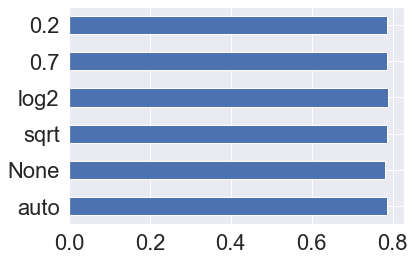

In [44]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.7, 0.2]

for max_features in max_features_options:
    model = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X_train, y_train)
    print(max_features, "option")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    print (" ")
    
pd.Series(results, max_features_options).plot(kind='barh')

### Min Sample Leafs

1 min samples
AUC Train:  0.8195644468899822
AUC Test:  0.6128303943363976
 
2 min samples
AUC Train:  0.778555705561086
AUC Test:  0.5878395666955285
 
3 min samples
AUC Train:  0.8682874031209153
AUC Test:  0.6228464884245152
 
4 min samples
AUC Train:  0.8448252986098982
AUC Test:  0.6065331541734073
 
5 min samples
AUC Train:  0.8896686788795635
AUC Test:  0.6269402798091976
 
6 min samples
AUC Train:  0.8697932649055892
AUC Test:  0.616525549858603
 
7 min samples
AUC Train:  0.8997508696332513
AUC Test:  0.6310539275829948
 
8 min samples
AUC Train:  0.8865327964266303
AUC Test:  0.6234585535399704
 
9 min samples
AUC Train:  0.9070072981203859
AUC Test:  0.6315853104085037
 
10 min samples
AUC Train:  0.896935423160043
AUC Test:  0.6261265628288827
 
20 min samples
AUC Train:  0.9194815393073809
AUC Test:  0.6351049182157343
 


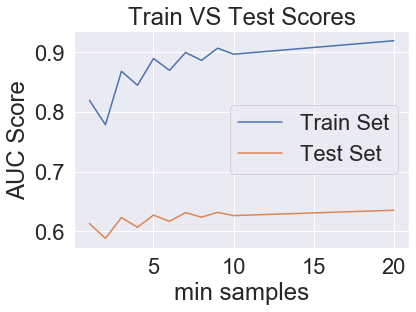

In [51]:
results = []
results2 = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(min_samples, oob_score=True, n_jobs=-1, random_state=42)
    
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(min_samples, 'min samples')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(min_samples_leaf_options, results, label='Train Set')
plt.plot(min_samples_leaf_options, results2, label='Test Set')
plt.xlabel('min samples')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="right")
plt.show()

In [60]:
model1 = RandomForestClassifier(random_state = 42,
                                  n_estimators = 50,
                                  max_depth = 60, 
                                  max_features = "log2",  min_samples_leaf = 20) 
rf1 = model1.fit(X_train, y_train) 
print(cross_val_score(rf1, X_train, y_train))
rf1.score(X_train,y_train)

[0.82322654 0.82065217 0.81590617]


0.8244576877234804

In [61]:
model2 = RandomForestClassifier(random_state = 42,
                                  n_estimators = 60,
                                  max_depth = 95, 
                                  max_features = "log2",  min_samples_leaf = 5) 
rf2 = model2.fit(X_train, y_train) 
print(cross_val_score(rf2, X_train, y_train))
rf2.score(X_train,y_train)

[0.82122426 0.81893593 0.81433271]


0.8438617401668653

In [71]:
model3 = RandomForestClassifier(random_state = 42,
                                  n_estimators = 65,
                                  max_depth = 95, 
                                  max_features = "log2",  min_samples_leaf = 1) 
rf3 = model3.fit(X_train, y_train) 
print(cross_val_score(rf3, X_train, y_train))
rf3.score(X_train,y_train)

[0.78346682 0.78160755 0.78386497]


0.9630035756853397

In [72]:
model4 = RandomForestClassifier(random_state = 42,
                                  n_estimators = 65,
                                  max_depth = 100, 
                                  max_features = "log2",  min_samples_leaf = 2) 
rf4 = model4.fit(X_train, y_train) 
print(cross_val_score(rf4, X_train, y_train))
rf4.score(X_train,y_train)

[0.81378719 0.8083524  0.80589329]


0.8860071513706794

In [73]:
pred3 = rf3.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf3.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.79


In [74]:
pred4 = rf4.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf4.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.82


In [75]:
pred1 = rf1.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf1.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.82


In [81]:
pred2 = rf2.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf2.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.82


In [82]:
# Confusion matrix
confmat = confusion_matrix(y_test, pred2)
print("The Confusion matrix:\n", confmat)
print("Precision Score:", round(precision_score(y_test, pred2), 2))
print("Recall Score:", round(recall_score(y_test, pred2), 2))

The Confusion matrix:
 [[6666  335]
 [1283  706]]
Precision Score: 0.68
Recall Score: 0.35


### Feature Importance

SEX          0.026361
EDUCATION    0.040280
MARRIAGE     0.023530
log_age      0.182357
log_limit    0.167716
PAY_0        0.370793
PAY_3        0.106601
PAY_5        0.082362
dtype: float64


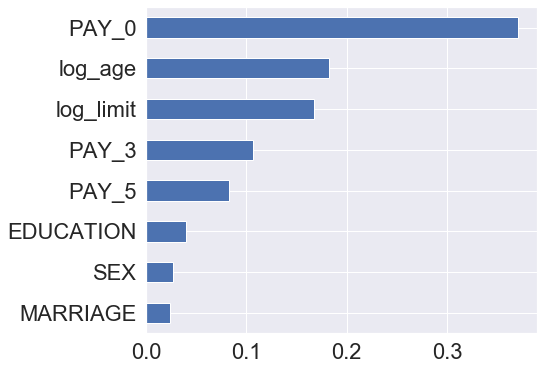

In [83]:
# Extracting feature importances from our model
feature_importances = pd.Series(rf2.feature_importances_, index=data.drop([target],1).columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))